In [1]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import uproot 
import awkward as ak
from pathlib import Path

from typing import Dict, List 
import re
import pickle
from tqdm import tqdm

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split



In [2]:
training_vars = ['jet_nTracks']
training_weight = ['equal_weight']


# Load Data

In [3]:
sample_path = '../../samples/sample_1500_2p8M_jets.pkl'
sample = pd.read_pickle(sample_path)

In [4]:
sample.columns

Index(['jet_pt', 'jet_eta', 'jet_nTracks', 'jet_trackWidth', 'jet_trackC1',
       'jet_trackBDT', 'jet_PartonTruthLabelID', 'equal_weight',
       'event_weight', 'flatpt_weight', 'target'],
      dtype='object')

# Train with default config

In [5]:
X = sample.iloc[:, :-1]
y = sample.iloc[:, -1]

X_dev,X_eval, y_dev,y_eval = train_test_split(X, y, test_size=0.1, random_state=456)
X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, test_size=0.1/0.9, random_state=789)

In [81]:
event_weight_idx = X.columns.get_loc('event_weight')
equal_weight_idx = X.columns.get_loc('equal_weight')
flatpt_weight_idx = X.columns.get_loc('flatpt_weight')

In [6]:
X_train[training_vars].head()

,jet_nTracks
2990151,25.0
5619014,43.0
1762478,26.0
15574,13.0
341104,26.0


In [7]:
X_train[training_weight].head()

,equal_weight
2990151,1.0
5619014,1.0
1762478,1.0
15574,1.0
341104,1.0


In [8]:
dt = DecisionTreeClassifier(max_depth=9,
                            min_samples_leaf=0.001,
                            max_features="log2")
bdt = AdaBoostClassifier(dt,
                         algorithm='SAMME',
                         n_estimators=1000,
                         learning_rate=0.1,
                         random_state=42)

bdt.fit(X_train[training_vars], y_train, sample_weight=X_train[training_weight].to_numpy().flatten())

### 23m 31.7s 

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=9,
                                                         max_features='log2',
                                                         min_samples_leaf=0.001),
                   learning_rate=0.1, n_estimators=1000, random_state=42)

In [17]:
bdt_filename = './BDT_explore_1500_ntrk_equalweight.model'
pickle.dump(bdt, open(bdt_filename, 'wb'))

# Predict on test datasets

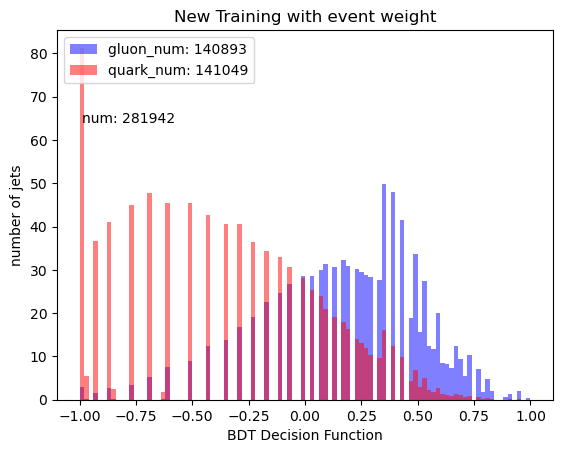

In [122]:
y_test_decisions = bdt.decision_function(X_test[training_vars])
y_test_gluon_id = np.where(y_test==1)[0]
y_test_quark_id = np.where(y_test==0)[0]
bins_scores = np.linspace(-1, 1, 101)
plt.hist(y_test_decisions[y_test_gluon_id], weights=X_test.iloc[y_test_gluon_id, X_test.columns.get_loc('event_weight')], bins= bins_scores, alpha=0.5, label='gluon'+f"_num: {len(y_test_gluon_id)}", color = 'blue') # add the weights! 
plt.hist(y_test_decisions[y_test_quark_id], weights=X_test.iloc[y_test_quark_id, X_test.columns.get_loc('event_weight')], bins= bins_scores, alpha=0.5, label='quark'+f"_num: {len(y_test_quark_id)}", color = 'red')
plt.legend(loc='upper left')
plt.text(0.05, 0.75, f"num: {len(X_test)}", transform=plt.gca().transAxes)
plt.xlabel("BDT Decision Function")
plt.ylabel("number of jets")
plt.title(r"New Training with event weight")
plt.show()

### Compare plotting with event weight and equal weight

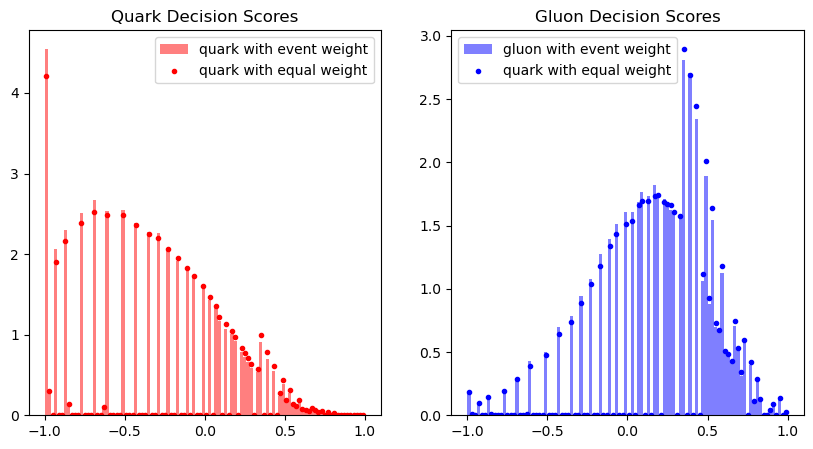

In [128]:
custom_bins = np.linspace(-1, 1, 101)
custom_bin_width = (custom_bins[1] - custom_bins[0])
custom_bin_center = (custom_bins[:-1] + custom_bins[1:]) / 2

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize = (10,5))

_, _, _ = ax0.hist(y_test_decisions[y_test_quark_id], weights=X_test.iloc[y_test_quark_id, event_weight_idx], bins= custom_bins, alpha=0.5, label='quark with event weight', color = 'red', density=True) 
bin_contents, _ = np.histogram(y_test_decisions[y_test_quark_id], weights=X_test.iloc[y_test_quark_id, equal_weight_idx], bins= custom_bins, density = True)
ax0.scatter(x =custom_bin_center, y = bin_contents, label='quark with equal weight', color = 'red', marker='.')
ax0.set_title('Quark Decision Scores')
ax0.legend()


_, _, _ = ax1.hist(y_test_decisions[y_test_gluon_id], weights=X_test.iloc[y_test_gluon_id, event_weight_idx], bins= custom_bins, alpha=0.5, label='gluon with event weight', color = 'blue', density=True) 
bin_contents, _ = np.histogram(y_test_decisions[y_test_gluon_id], weights=X_test.iloc[y_test_gluon_id, equal_weight_idx], bins= custom_bins, density = True)
ax1.scatter(x =custom_bin_center, y = bin_contents, label='quark with equal weight', color = 'blue', marker='.')
ax1.set_title('Gluon Decision Scores')
ax1.legend()

# _, _, _ = ax1.hist(y_test_decisions[y_test_gluon_id], weights=X_test.iloc[y_test_gluon_id, X_test.columns.get_loc('event_weight')], bins= custom_bins, alpha=0.5, label='gluon'+f"_num: {len(y_test_gluon_id)}", color = 'blue', density=True) 
# _, _, _ = ax1.hist(y_test_decisions[y_test_gluon_id], weights=X_test.iloc[y_test_gluon_id, X_test.columns.get_loc('equal_weight')], bins= custom_bins, alpha=0.5, label='gluon'+f"_num: {len(y_test_gluon_id)}", color = 'red', density=True) 
# ax1.set_title('Gluon Decision Scores')

# Overtrain validation

In [100]:
y_test_decisions = bdt.decision_function(X_test[training_vars])
y_train_decisions = bdt.decision_function(X_train[training_vars])


y_test_decisions_gluon = y_test_decisions[np.where(y_test==1)]
y_test_decisions_quark = y_test_decisions[np.where(y_test==0)]
y_train_decisions_gluon = y_train_decisions[np.where(y_train==1)]
y_train_decisions_quark = y_train_decisions[np.where(y_train==0)]
decisions = []
decisions.append(y_train_decisions_gluon)
decisions.append(y_train_decisions_quark)
decisions.append(y_test_decisions_gluon)
decisions.append(y_test_decisions_quark)

Text(0.5, 1.0, 'Overtraining test')

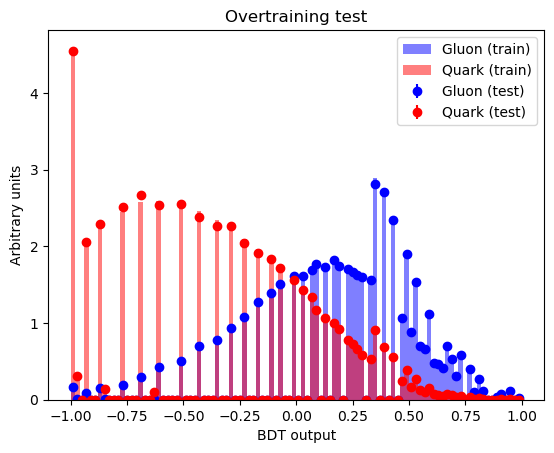

In [101]:
custom_bins = np.linspace(-1, 1, 101)
custom_bin_width = (custom_bins[1] - custom_bins[0])
custom_bin_center = (custom_bins[:-1] + custom_bins[1:]) / 2

fig, ax = plt.subplots()
ax.hist(decisions[0], weights = X_train.iloc[np.where(y_train==1)[0], event_weight_idx],
            color='b', alpha=0.5, bins=custom_bins,
            histtype='stepfilled', density=True,
            label='Gluon (train)')
ax.hist(decisions[1], weights = X_train.iloc[np.where(y_train==0)[0], event_weight_idx],
            color='r', alpha=0.5, bins=custom_bins,
            histtype='stepfilled', density=True,
            label='Quark (train)')

hist, bins = np.histogram(decisions[2], weights=X_test.iloc[np.where(y_test==1)[0], event_weight_idx],
                            bins=custom_bins,  density=True)
scale = len(decisions[2]) / sum(hist)
err = np.sqrt(hist * scale) / scale

plt.errorbar(custom_bin_center, hist, yerr=err, fmt='o', c='b', label='Gluon (test)')

hist, bins = np.histogram(decisions[3], weights=X_test.iloc[np.where(y_test==0)[0], event_weight_idx],
                            bins=custom_bins, density=True)
scale = len(decisions[2]) / sum(hist)
err = np.sqrt(hist * scale) / scale

plt.errorbar(custom_bin_center, hist, yerr=err, fmt='o', c='r', label='Quark (test)')
plt.xlabel("BDT output")
plt.ylabel("Arbitrary units")
plt.legend(loc='best')
plt.title("Overtraining test")

# Test Forward/Central

In [130]:
X.head()

,jet_pt,jet_eta,jet_nTracks,jet_trackWidth,jet_trackC1,jet_trackBDT,jet_PartonTruthLabelID,equal_weight,event_weight,flatpt_weight
1046823,1765.118652,0.765842,36.0,0.041832,0.226598,0.174245,2.0,1.0,0.002186,0.000002
5717242,1605.052368,-0.346835,14.0,0.020056,0.105758,-0.355126,2.0,1.0,0.011307,0.000004
454956,1673.008789,0.259815,6.0,0.008405,0.096004,-0.586819,2.0,1.0,0.013519,0.000007
2294496,1725.240845,-0.696387,16.0,0.029819,0.157534,-0.262760,1.0,1.0,0.001749,0.000001
3708534,1508.333740,-0.228486,15.0,0.027709,0.214327,-0.154856,1.0,1.0,0.020987,0.000005


In [76]:
X_train.iloc[0, 2]

25.0

In [ ]:
bins=np.linspace(-1, 1, 101)
plt.hist(decisions[0], weights = X_train[:,7][np.where(y_train==1)],
            color='b', alpha=0.5, bins=bins,
            histtype='stepfilled', density=True,
            label='S (train)')
plt.hist(decisions[1], weights = X_train[:,7][np.where(y_train==0)],
            color='r', alpha=0.5,  bins=bins,
            histtype='stepfilled', density=True,
            label='B (train)')

# hist, bins = np.histogram(decisions[2], weights=X_test[:,7][np.where(y_test==1)],
#                             bins=bins,  density=True)
# scale = len(decisions[2]) / sum(hist)
# err = np.sqrt(hist * scale) / scale

# width = (bins[1] - bins[0])
# center = (bins[:-1] + bins[1:]) / 2
# plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='S (test)')

# hist, bins = np.histogram(decisions[3], weights=X_test[:,7][np.where(y_test==0)],
#                             bins=bins, density=True)
# scale = len(decisions[2]) / sum(hist)
# err = np.sqrt(hist * scale) / scale

# plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='B (test)')

plt.xlabel("BDT output")
plt.ylabel("Arbitrary units")
plt.legend(loc='best')
plt.title("Overtraining test")
# plt.savefig("overfitting_test_flatptweight.png",dpi=300)

In [52]:
y_test_proba = bdt.predict_proba(X_test[training_vars])[:,1]

In [79]:
y_test_proba[0:5]

array([0.56280931, 0.39224003, 0.57987771, 0.6913701 , 0.45818356])

In [39]:
y_test_decisions[0:5]

array([ 0.2525714 , -0.43790606,  0.32227139,  0.80653247, -0.16765737])

In [118]:
X_test

,jet_pt,jet_eta,jet_nTracks,jet_trackWidth,jet_trackC1,jet_trackBDT,jet_PartonTruthLabelID,equal_weight,event_weight,flatpt_weight
5152157,1511.767456,-0.835579,31.0,0.033250,0.226004,0.219113,21.0,1.0,0.017789,0.000004
340772,1507.681030,1.060204,16.0,0.014031,0.110704,-0.293991,3.0,1.0,0.023751,0.000005
3464416,1505.417603,0.050792,34.0,0.069803,0.274100,0.190910,21.0,1.0,0.006653,0.000001
2833270,1799.900024,-0.142748,69.0,0.152615,0.329555,0.375030,21.0,1.0,0.001814,0.000002
850581,1659.813477,-0.560987,20.0,0.024189,0.140443,-0.153379,2.0,1.0,0.002242,0.000001
...,...,...,...,...,...,...,...,...,...,...
1358891,1779.181763,-0.990423,23.0,0.008141,0.137853,-0.011229,2.0,1.0,0.001080,0.000001
1239706,1836.874756,-0.171852,41.0,0.033097,0.237033,0.352322,21.0,1.0,0.001703,0.000002
1980430,1869.980469,-0.017666,23.0,0.027592,0.131618,-0.148327,21.0,1.0,0.001766,0.000003
2228246,1753.057983,-0.223684,60.0,0.113249,0.309268,0.403340,21.0,1.0,0.007651,0.000007


In [ ]:
y_test_gluon_id = np.where(y_test==1)[0]
y_test_quark_id = np.where(y_test==0)[0]
bins_scores = np.linspace(-1, 1, 101)
plt.hist(y_test_decisions[y_test_gluon_id], weights=X_test.iloc[y_test_gluon_id, X_test.columns.get_loc('equal_weight')], bins= bins_scores, alpha=0.5, label='gluon'+f"_num: {len(y_test_gluon_id)}", color = 'blue') # add the weights! 
plt.hist(y_test_decisions[y_test_quark_id], weights=X_test.iloc[y_test_quark_id, X_test.columns.get_loc('equal_weight')], bins= bins_scores, alpha=0.5, label='quark'+f"_num: {len(y_test_quark_id)}", color = 'red')
plt.legend(loc='upper left')
plt.text(0.05, 0.75, f"num: {len(X_test)}", transform=plt.gca().transAxes)
plt.xlabel("BDT Decision Function")
plt.ylabel("number of jets")
plt.title(r"New Training with equal weight")
plt.show()


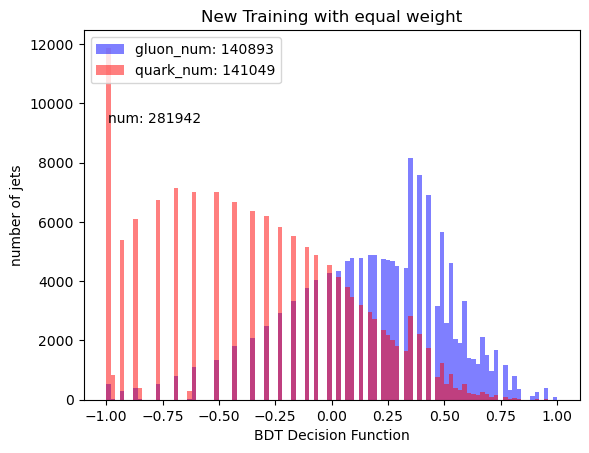

In [119]:
y_test_gluon_id = np.where(y_test==1)[0]
y_test_quark_id = np.where(y_test==0)[0]
bins_scores = np.linspace(-1, 1, 101)
plt.hist(y_test_decisions[y_test_gluon_id], weights=X_test.iloc[y_test_gluon_id, X_test.columns.get_loc('equal_weight')], bins= bins_scores, alpha=0.5, label='gluon'+f"_num: {len(y_test_gluon_id)}", color = 'blue') # add the weights! 
plt.hist(y_test_decisions[y_test_quark_id], weights=X_test.iloc[y_test_quark_id, X_test.columns.get_loc('equal_weight')], bins= bins_scores, alpha=0.5, label='quark'+f"_num: {len(y_test_quark_id)}", color = 'red')
plt.legend(loc='upper left')
plt.text(0.05, 0.75, f"num: {len(X_test)}", transform=plt.gca().transAxes)
plt.xlabel("BDT Decision Function")
plt.ylabel("number of jets")
plt.title(r"New Training with equal weight")
plt.show()


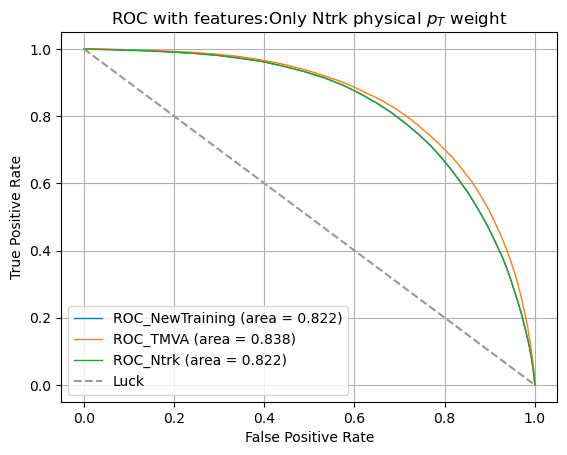

In [47]:
from sklearn.metrics import roc_curve, auc

def Draw_ROC_all(y, decisions, y_tmva, y_ntrk, X_weight, features):
    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(y, decisions, sample_weight = X_weight)
    fpr_tmva, tpr_tmva, thresholds_tmva = roc_curve(y, y_tmva, sample_weight = X_weight)
    fpr_ntrk, tpr_ntrk, thresholds_ntrk =  roc_curve(y, y_ntrk, sample_weight = X_weight)

    roc_auc = auc(fpr, tpr)
    roc_auc_tmva = auc(fpr_tmva, tpr_tmva)
    roc_auc_ntrk = auc(fpr_ntrk, tpr_ntrk)


    plt.plot(1-fpr, tpr, lw=1, label='ROC_NewTraining (area = %0.3f)'%(roc_auc))
    plt.plot(1-fpr_tmva, tpr_tmva, lw=1, label='ROC_TMVA (area = %0.3f)'%(roc_auc_tmva))
    plt.plot(1-fpr_ntrk, tpr_ntrk, lw=1, label='ROC_Ntrk (area = %0.3f)'%(roc_auc_ntrk))

    plt.plot([0, 1], [1, 0], '--', color=(0.6, 0.6, 0.6), label='Luck')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC with features:{features}'+r" physical $p_{T}$ weight")
    plt.legend(loc="lower left")
    plt.grid()
    plt.savefig("ROC_physicalweight.png")
    plt.show()

Draw_ROC_all(y_test, y_test_decisions, y_tmva=X_test.iloc[:,X_test.columns.get_loc('jet_trackBDT')] , y_ntrk=X_test.iloc[:,X_test.columns.get_loc('jet_nTracks')], X_weight=X_test['event_weight'], features="Only Ntrk")


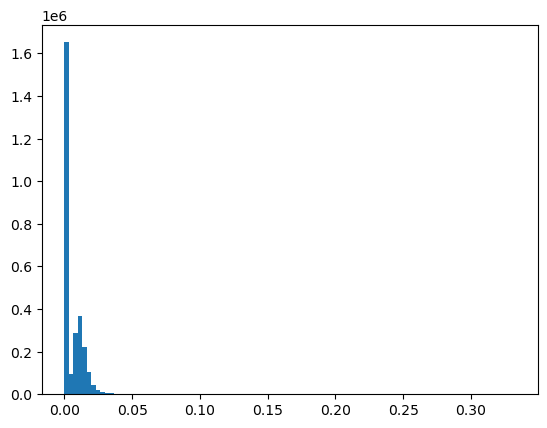

In [66]:
_, _, _  = plt.hist(sample['event_weight'], bins=100)

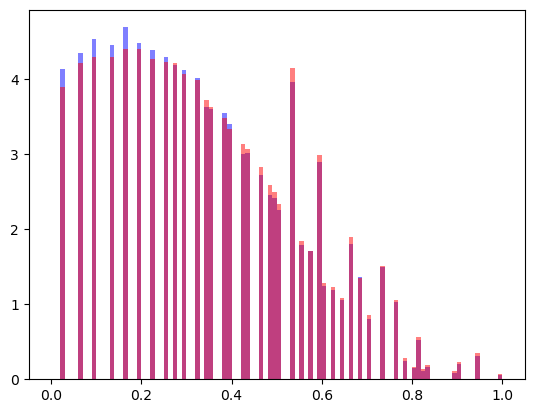

In [63]:
t1_bin_contents, _, _ = plt.hist(y_test_decisions[y_test_gluon_id], weights=X_test.iloc[y_test_gluon_id, X_test.columns.get_loc('event_weight')], bins= bins_scores, alpha=0.5, label='gluon'+f"_num: {len(y_test_gluon_id)}", color = 'blue', density=True) # add the weights! 
t2_bin_contents, _, _ = plt.hist(y_test_decisions[y_test_gluon_id], weights=X_test.iloc[y_test_gluon_id, X_test.columns.get_loc('equal_weight')], bins= bins_scores, alpha=0.5, label='gluon'+f"_num: {len(y_test_gluon_id)}", color = 'red', density=True) # add the weights! 


# Backup

In [ ]:
y_test_decisions = bdt.decision_function(X_eval[training_vars])

y_test_decisions_gluon = y_test_decisions[np.where(y_eval==1)]
y_test_decisions_quark = y_test_decisions[np.where(y_eval==0)]
y_train_decisions_gluon = y_train_decisions[np.where(y_train==1)]
y_train_decisions_quark = y_train_decisions[np.where(y_train==0)]
decisions = []
decisions.append(y_train_decisions_gluon)
decisions.append(y_train_decisions_quark)
decisions.append(y_test_decisions_gluon)
decisions.append(y_test_decisions_quark)


custom_bins = np.linspace(-1, 1, 101)
custom_bin_width = (custom_bins[1] - custom_bins[0])
custom_bin_center = (custom_bins[:-1] + custom_bins[1:]) / 2

fig, ax = plt.subplots()
ax.hist(decisions[0], weights = X_train.iloc[np.where(y_train==1)[0], event_weight_idx],
            color='b', alpha=0.5, bins=custom_bins,
            histtype='stepfilled', density=True,
            label='Gluon (train)')
ax.hist(decisions[1], weights = X_train.iloc[np.where(y_train==0)[0], event_weight_idx],
            color='r', alpha=0.5, bins=custom_bins,
            histtype='stepfilled', density=True,
            label='Quark (train)')

hist, bins = np.histogram(decisions[2], weights=X_eval.iloc[np.where(y_eval==1)[0], event_weight_idx],
                            bins=custom_bins,  density=True)
scale = len(decisions[2]) / sum(hist)
err = np.sqrt(hist * scale) / scale

plt.errorbar(custom_bin_center, hist, yerr=err, fmt='o', c='b', label='Gluon (test)')

hist, bins = np.histogram(decisions[3], weights=X_eval.iloc[np.where(y_eval==0)[0], event_weight_idx],
                            bins=custom_bins, density=True)
scale = len(decisions[2]) / sum(hist)
err = np.sqrt(hist * scale) / scale

plt.errorbar(custom_bin_center, hist, yerr=err, fmt='o', c='r', label='Quark (test)')
plt.xlabel("BDT output")
plt.ylabel("Arbitrary units")
plt.legend(loc='best')
plt.title("Overtraining test")



In [116]:
bins = [[0.3, 0.5, 0.7], [0.3, 0.7]]
values = np.random.random((10, 2))
digitized = []
for i in range(len(bins)):
    digitized.append(np.digitize(values[:, i], bins[i], right=False))
digitized = np.concatenate(digitized).reshape(10, 2)

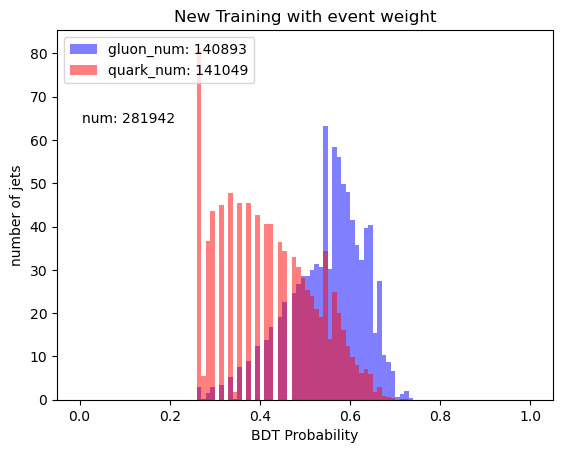

In [121]:
y_test_gluon_id = np.where(y_test==1)[0]
y_test_quark_id = np.where(y_test==0)[0]
bins_scores = np.linspace(0, 1, 101)
plt.hist(y_test_proba[y_test_gluon_id], weights=X_test.iloc[y_test_gluon_id, X_test.columns.get_loc('event_weight')], bins= bins_scores, alpha=0.5, label='gluon'+f"_num: {len(y_test_gluon_id)}", color = 'blue') # add the weights! 
plt.hist(y_test_proba[y_test_quark_id], weights=X_test.iloc[y_test_quark_id, X_test.columns.get_loc('event_weight')], bins= bins_scores, alpha=0.5, label='quark'+f"_num: {len(y_test_quark_id)}", color = 'red')
plt.legend(loc='upper left')
plt.text(0.05, 0.75, f"num: {len(X_test)}", transform=plt.gca().transAxes)
plt.xlabel("BDT Probability")
plt.ylabel("number of jets")
plt.title(r"New Training with event weight")
plt.show()
